Enter the Path of the image (from the frog_images_per_head folder):  C:\Users\Prakhar\Downloads\frog_images\Beduka Amboli\_1362-680-5b72edd6a757e-1_aug_450.jpg
Enter the type locality (e.g., koyna):  Amboli, Maharashtra, India
Describe the coloration pattern:  Spotted across the body
Enter leg length:  Medium length
Enter preferred elevation:  mid-elevation
Enter skin type:  smooth


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step


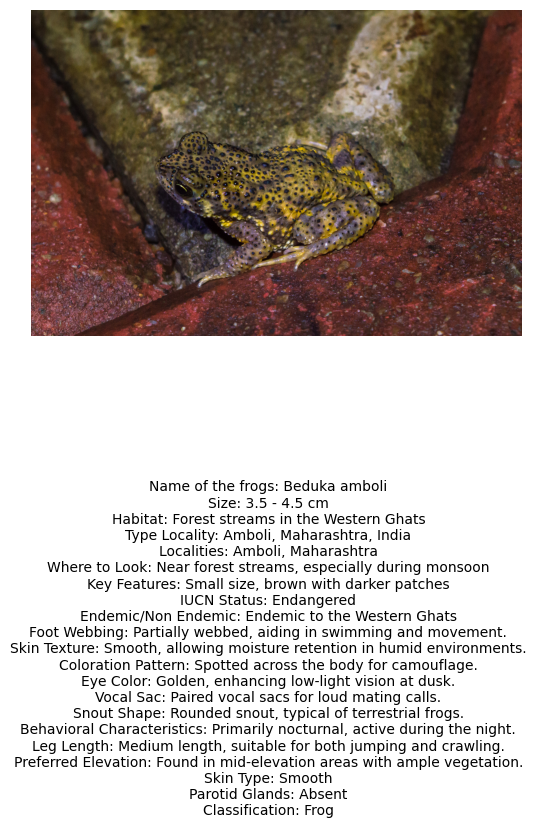

Output displayed successfully.


In [3]:
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import os
import tensorflow as tf

# Load the frog species data
df = pd.read_excel(r"C:\Users\Prakhar\Downloads\CpiFinal.xlsx")

# Load the trained image classification model
model = load_model("frog_species_classifier1.keras", compile=False)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Define the path to the folder with frog images
frog_images_folder = r"C:\Users\Prakhar\Downloads\frog_images_per_head"

# Define a function to avoid retracing warnings (optional)
@tf.function
def predict_image(img_array):
    return model.predict(img_array)

def get_user_input():
    img_path = input("Enter the Path of the image (from the frog_images_per_head folder): ")
    features = {
        "Type Locality": input("Enter the type locality (e.g., koyna): "),
        "Coloration Pattern": input("Describe the coloration pattern: "),
        "Leg Length": input("Enter leg length: "),
        "Preferred Elevation": input("Enter preferred elevation: "),
        "Skin Type": input("Enter skin type: ")
    }
    return img_path, features

def preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))  # Resize image
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = img_array.reshape(1, *img_array.shape)
    return img_array

def classify_image(img_path):
    img_array = preprocess_image(img_path)
    # Using eager execution (TensorFlow 2.x) to get the numpy value directly
    prediction = model.predict(img_array)  # Perform prediction without tf.function
    species_index = tf.argmax(prediction, axis=-1).numpy()[0]  # Use .numpy() here on eager tensor
    confidence = tf.reduce_max(prediction, axis=-1).numpy()[0]  # Use .numpy() here as well
    return species_index, confidence


def match_features(features, df):
    match_scores = []
    for _, row in df.iterrows():
        score = 0
        # Match type locality
        best_match, match_score = process.extractOne(features["Type Locality"], [str(row["Type Locality"])])
        score += match_score
        # Match other features
        for key, value in features.items():
            if key != "Type Locality":
                best_match, match_score = process.extractOne(value, [str(row[key])])
                score += match_score
        match_scores.append(score)
    best_match_index = match_scores.index(max(match_scores))
    return df.iloc[best_match_index]

def display_image_and_data(species_data):
    # Fetch the species name from the matched data
    species_name = species_data["Name of the frogs"]

    # Replace spaces with underscores in the species name to match folder format
    species_name_folder = species_name.replace(" ", "_")

    # Define the path to the subfolder named after the species
    species_folder = os.path.join(frog_images_folder, species_name_folder)

    if not os.path.exists(species_folder):
        print(f"Species folder not found in 'frog_images_per_head': {species_name_folder}")
        return

    # Get the first image from the species folder (you can modify this to fetch specific images if needed)
    species_images = os.listdir(species_folder)
    if not species_images:
        print(f"No images found for {species_name} in the folder.")
        return

    img_path = os.path.join(species_folder, species_images[0])  # Assuming the first image in the folder
    img = load_img(img_path)
    plt.imshow(img)
    plt.axis('off')

    # Display detailed species information below the image (All 22 columns)
    info_text = "\n".join([f"{col}: {species_data[col]}" for col in df.columns])
    # Reduce the bottom margin to bring the text closer to the image
    plt.gcf().text(0.5, -0.1, info_text, ha='center', va='top', fontsize=10, wrap=True)
    plt.subplots_adjust(bottom=0.2)  # Adjust bottom margin to reduce space
    plt.show()


def main():
    img_filename, features = get_user_input()
    img_path = os.path.join(frog_images_folder, img_filename)

    if not os.path.exists(img_path):
        print(f"Invalid image path: {img_filename} not found in 'frog_images_per_head' folder.")
        return

    # Run image classification model
    species_index, confidence = classify_image(img_path)
    model_match_data = df.iloc[species_index]

    # String matching result
    text_match_data = match_features(features, df)

    # Choose between model or string match based on confidence
    if confidence < 0.75 or text_match_data["Name of the frogs"] != model_match_data["Name of the frogs"]:
        species_data = text_match_data
    else:
        species_data = model_match_data

    display_image_and_data(species_data)
    print("Output displayed successfully.")

if __name__ == "__main__":
    main()